# <center>你真的比算法更懂人脸吗？</center>

By [青衣极客 Blue Geek](https://mp.weixin.qq.com/s/HVOP2JmuEyv8aCmgHFEsKw)

In 2020-01-16

我们常常在一些场合需要描述人脸的一些特征，比如眉毛的粗细，眼睛的大小和形状，头发的曲直等等。这些特征往往能够给人比较深刻的印象，对于判断一个人的精神状态、心理情绪以及态度观点都有很重要的作用。人类的眼睛往往能在不经意间捕获这些信息并加以利用，大多数时候自己都难以感觉到我们的大脑在进行如此精细的分析。不过现在我们必须对这些人类的智能进行精细描述，从而指导机器学习的建模。

## 1. 那些有趣的人脸特征

用语言描述人的面部特征的时候往往会觉得毫无规律可循，比如嘴巴的大小、眉毛的粗细或者鼻子的大小，这些特征都难以量化。因此只能根据每个人的视觉感受来进行描述。对于人脸有多少个特征这种问题是完全不能给出准确答案的，因此只能根据时间、精力和研究兴趣加以筛选。在以上两个条件之下，再来讨论人类面部特征这个话题就可以具体得多。

### (1) 读取标注

一个公开的数据集[CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)中包含了40个人脸特征属性的标注，基本囊括了我们感兴趣的一些特征。该数据集提供了大约20万个样本，其中训练集大约16万个，验证集大约2万个，测试集大约2万个。样本数量的充足对于使用深度学习模型而言更有优势。

In [1]:
import os
import pandas as pd
# set dataset direcotry
dataset_dir = os.path.expanduser('~/Database/Dataset/CelebA-dataset/')
# set annotation path
attr_path = os.path.join(dataset_dir, 'Anno', 'list_attr_celeba.txt')
# set partition path, which can split dataset into trainset,valset and testset
partition_path = os.path.join(dataset_dir, 'Eval', 'list_eval_partition.txt')
# set image directory in which images are aligned 
img_dir = os.path.join(dataset_dir, 'Img', 'img_align_celeba') 
# read partition info
part_df = pd.read_csv(partition_path, sep='\s+', skiprows=0, header=None)
part_df.columns = ['filename', 'partition']
part_df = part_df.set_index('filename')
# read annotations
attr_df = pd.read_csv(attr_path, sep='\s+', skiprows=1)
attr_df[attr_df == -1] = 0
# merge annotation and partition information
df = attr_df.merge(part_df, left_index=True, right_index=True)
# split into train, val, test partition
train_df = df.loc[df['partition'] == 0].drop(['partition'], axis=1)
val_df = df.loc[df['partition'] == 1].drop(['partition'], axis=1)
test_df = df.loc[df['partition'] == 2].drop(['partition'], axis=1)

print('num_sample on training:{}'.format(train_df.shape[0]))
print('num_sample on validating:{}'.format(val_df.shape[0]))
print('num_sample on testing:{}'.format(test_df.shape[0]))

num_sample on training:162770
num_sample on validating:19867
num_sample on testing:19962


### (2) 读取属性名翻译

[CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)数据集中的属性名都是英文的，这里进行一下翻译。

|英文属性|中文名|英文属性|中文名|英文属性|中文名|英文属性|中文名|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|5 o'Clock Shadow|短胡须|Arched Eyebrows|拱形的眉毛|Attractive|有魅力|Bags Under Eyes|眼袋|
|Bald|秃|Bangs|刘海|Big Lips|厚嘴唇|Big Nose|大鼻子|
|Black Hair|黑发|Blond Hair|金发|Blurry|模糊的|Brown Hair|棕色的头发|
|Bushy Eyebrows|浓密的眉毛|Chubby|胖乎乎的|Double Chin|双下巴|Eyeglasses|眼镜|
|Goatee|山羊皮|Gray Hair|白发|Heavy Makeup|重妆|High Cheekbones|高颧骨|
|Male|男性|Mouth Slightly Open|嘴巴稍微张开|Mustache|长胡子|Narrow_Eyes|窄眼|
|No Beard|没胡须|Oval Face|鹅蛋脸|Pale Skin|皮肤苍白|Pointy Nose|尖鼻|
|Receding Hairline|后退发际线|Rosy Cheeks|红扑扑的脸|Sideburns|鬓角|Smiling|面带微笑|
|Straight Hair|直发|Wavy Hair|卷发|Wearing Earrings|戴耳环|Wearing Hat|戴着帽子|
|Wearing Lipstick|涂口红|Wearing Necklace|戴项链|Wearing Necktie|打着领带|Young|年轻|

所列出的这些人脸特征属性可以被标记为有(1)或者没有(-1)，比如“男性”如果被标记为1则表示人脸为男性，如果被标记为-1则表示该人脸为女性。由于需要研究的面部属性有多个，因此也是一种多目标的问题。

In [4]:
import json
# get all attritions
attrs_list = train_df.columns.tolist()
# get dict to mapping English to Chinese
with open('../data/bg60/attr_trans.json', 'r') as fid:
    attrs_en2ch = json.load(fid)
print(attrs_en2ch)

{'5_o_Clock_Shadow': '短胡须', 'Arched_Eyebrows': '拱形的眉毛', 'Attractive': '有魅力', 'Bags_Under_Eyes': '眼袋', 'Bald': '秃', 'Bangs': '刘海', 'Big_Lips': '厚嘴唇', 'Big_Nose': '大鼻子', 'Black_Hair': '黑发', 'Blond_Hair': '金发', 'Blurry': '模糊的', 'Brown_Hair': '棕色的头发', 'Bushy_Eyebrows': '浓密的眉毛', 'Chubby': '胖乎乎的', 'Double_Chin': '双下巴', 'Eyeglasses': '眼镜', 'Goatee': '山羊皮', 'Gray_Hair': '白发', 'Heavy_Makeup': '重妆', 'High_Cheekbones': '高颧骨', 'Male': '男性', 'Mouth_Slightly_Open': '嘴巴稍微张开', 'Mustache': '长胡子', 'Narrow_Eyes': '窄眼', 'No_Beard': '没胡须', 'Oval_Face': '鹅蛋脸', 'Pale_Skin': '皮肤苍白', 'Pointy_Nose': '尖鼻', 'Receding_Hairline': '后退发际线', 'Rosy_Cheeks': '红扑扑的脸', 'Sideburns': '鬓角', 'Smiling': '面带微笑', 'Straight_Hair': '直发', 'Wavy_Hair': '卷发', 'Wearing_Earrings': '戴耳环', 'Wearing_Hat': '戴着帽子', 'Wearing_Lipstick': '涂口红', 'Wearing_Necklace': '戴项链', 'Wearing_Necktie': '打着领带', 'Young': '年轻'}


### (3) 挑选属性最多的样本

这里就在训练集中挑选一个属性最多样本进行展示。在该数据集中的图像都是已经配准对齐之后的，专业术语称之为“aligned”。在对人脸进行一些较高阶分析时，一般都需要先对人脸进行对齐。这样做的好处是保证了人脸在各种情况下表观信息在图像中的位置大体一致，从而提高泛化能力，训练过程也更容易收敛。

In [5]:
# find a sample which includes the most attributions
max_attrs, max_index = 0, ''
for idx, row in train_df.iterrows():
    num_attrs = sum(row.values)
    if num_attrs > max_attrs:
        max_attrs = num_attrs
        max_index = idx
print('find image:{}'.format(max_index))

find image:014308.jpg


<IPython.core.display.Javascript object>


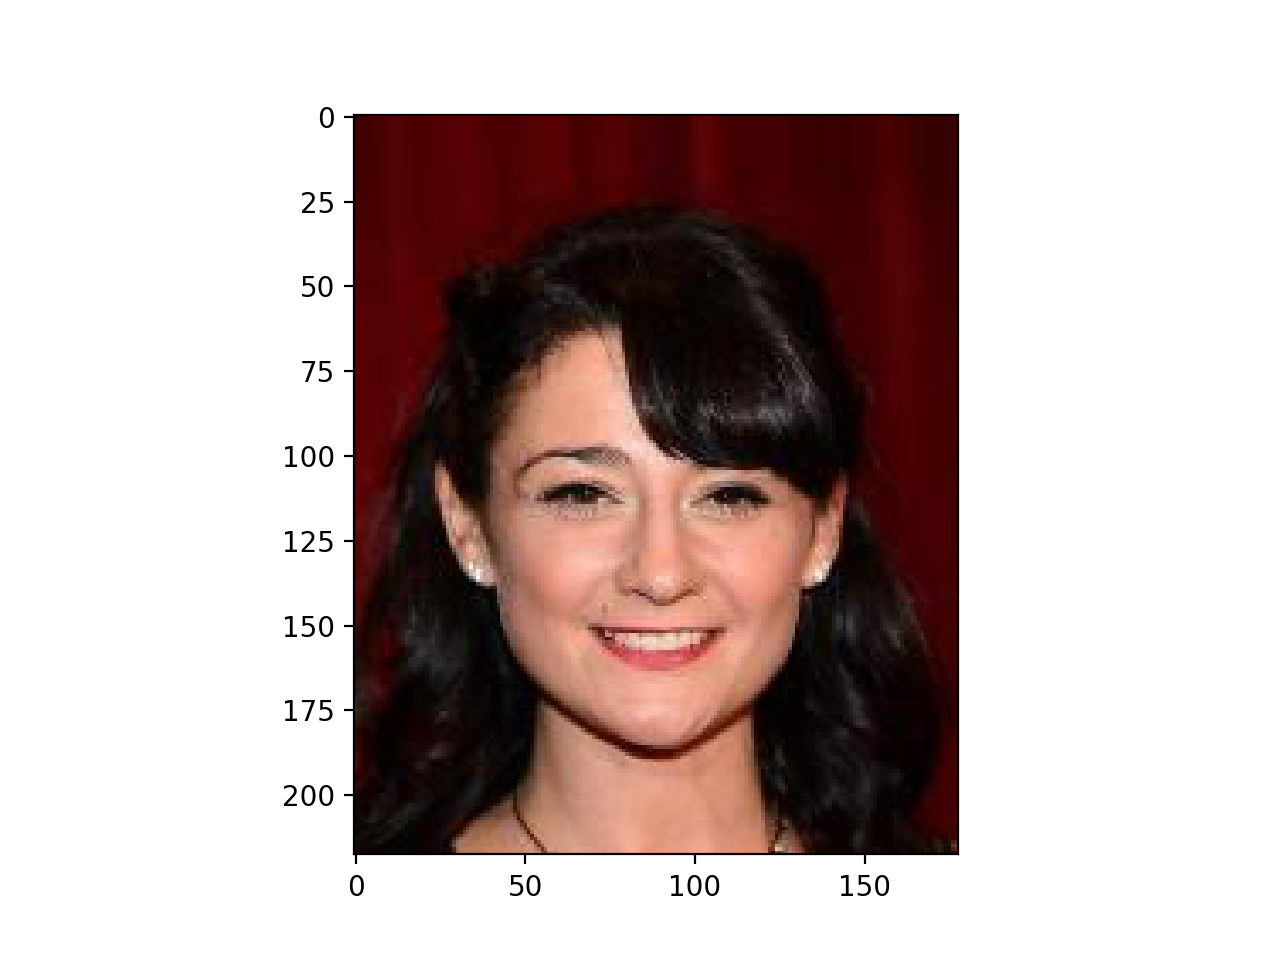

In [6]:
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
# show image
img_path = os.path.join(img_dir, max_index)
img = plt.imread(img_path)
plt.imshow(img)
plt.imsave('../output/max_attrs.png', img)

### (4) 打印样本属性中文名

In [7]:
def get_attrs_from_index(index):
    row = train_df.loc[max_index]
    max_attrs_list = []
    for name, value in row.iteritems():
        if value > 0:
            max_attrs_list.append(attrs_en2ch[name])
    return max_attrs_list
# print all attributions
print(get_attrs_from_index(max_index))

['拱形的眉毛', '有魅力', '眼袋', '刘海', '大鼻子', '黑发', '浓密的眉毛', '重妆', '高颧骨', '嘴巴稍微张开', '窄眼', '没胡须', '鹅蛋脸', '红扑扑的脸', '面带微笑', '卷发', '戴耳环', '涂口红', '戴项链', '年轻']


## 2. 一个简单的多目标模型

对于这样需要识别多个人脸属性的问题，可以对每个属性分别建模，也就是每个属性都可以建立一个分类器，40个属性也就需要40个分类器。可以看出，这种分别建模的方式比较麻烦，而且也有些浪费资源。在这种分类问题中，对人脸描述子的需求基本是一致的，只是在最终判断属性上存在一些差异。对于这种情况，可以使用多目标建模，人脸图像描述子的抽取使用相同的模块，在最终得到属性的类别概率时使用不同分类实例即可。

这里采用vggnet中的vgg19，该网络有16个卷积层和3个全连接层，只是在最后一个全连接层对40个属性分别建模二值概率分布。
如图。

在构建总的损失函数时，对每个属性都使用cross-entropy损失，然后对所有属性计算损失的均值。通过优化总的损失函数来调整神经网络对每个人脸特征属性的预测。

在训练这个多目标模型的时候遇到了不收敛的问题，这也是研究深度学习模型时比较常见的问题。对于这种问题可能存在以下几种可能的原因：
(1) 网络结构存在错误，将网络结构打印成图或者列表查看即可；
(2) 模型复杂度不足，难以拟合复杂数据，建议使用单个batch数据训练，观察能否收敛，如果单batch能收敛则可以增大模型复杂度；
(3) 学习率过大或者过小，学习率过大容易出现不收敛且损失函数值变化剧烈，学习率过小出现不收敛常常表现为损失函数值无变化；
(4) 输入数据类型与神经网络框架的数据类型不一致，这个问题直接查看即可，一般使用float32；
(5) 损失函数实现出错；
(6) 网络过深，导致梯度信息难以有效传播，这种情况可以检查神经网络前几层参数变化；

我们遇到的不收敛的原因是学习率过大，将学习率调整到$10^{-5}$之后就能够正常训练了，训练过程的指标变化曲线图如图所示。

通过训练过程的指标曲线可以发现，大约在5个epoch时得到最好的模型，随后就出现过拟合的情况。这时如果需要进一步提高验证集的精度，可以增加一些dropout层或者对数据样本进行一些增强操作以提高泛化能力。


<IPython.core.display.Javascript object>


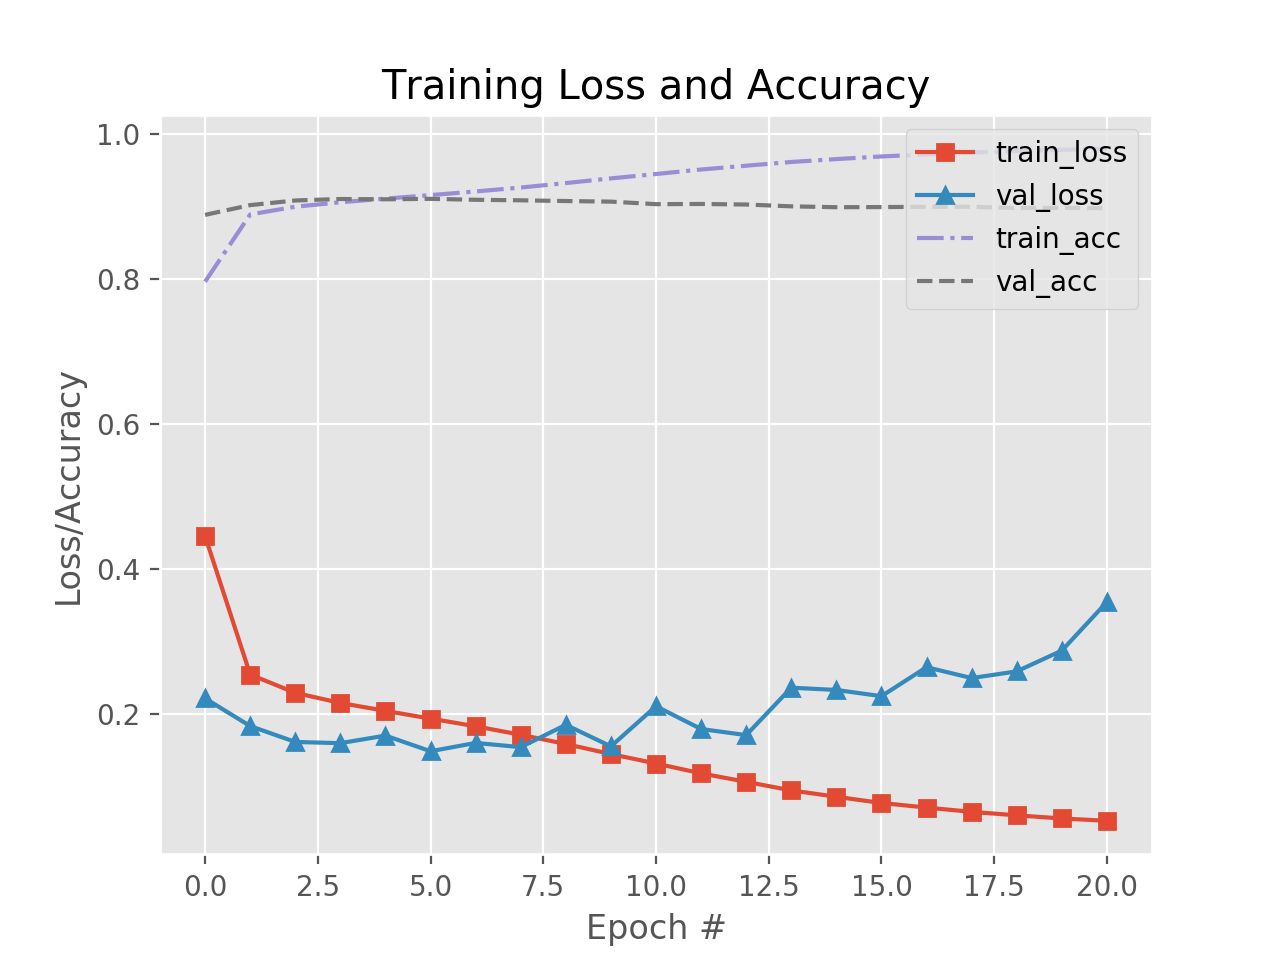

In [16]:
# read training log
log_path = '../data/bg60/training.log'
df = pd.read_csv(log_path, sep=',')
epochs = df['epoch'].values
train_loss = df['loss'].values
train_acc = df['accuracy'].values
val_loss = df['val_loss'].values
val_acc = df['val_accuracy'].values

# plot curve
plt.style.use("ggplot")
plt.figure()
plt.plot(epochs, train_loss, '-s', label='train_loss')
plt.plot(epochs, val_loss, '-^', label='val_loss')
plt.plot(epochs, train_acc, '-.', label='train_acc')
plt.plot(epochs, val_acc, '--',label='val_acc')
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.savefig('images/bg60/train_curve.png')

## 3. 说一说模型的效果

训练完成之后，将最好的模型保存到文件，然后就可以在测试集上进行测试了。在不使用batch-normalization的情况下，可以达到90.17%的精度；加上batch-normalization之后可以达到90.62%的精度。总体而言，精度改善不大，但是训练收敛的速度稍快一些。

<IPython.core.display.Javascript object>


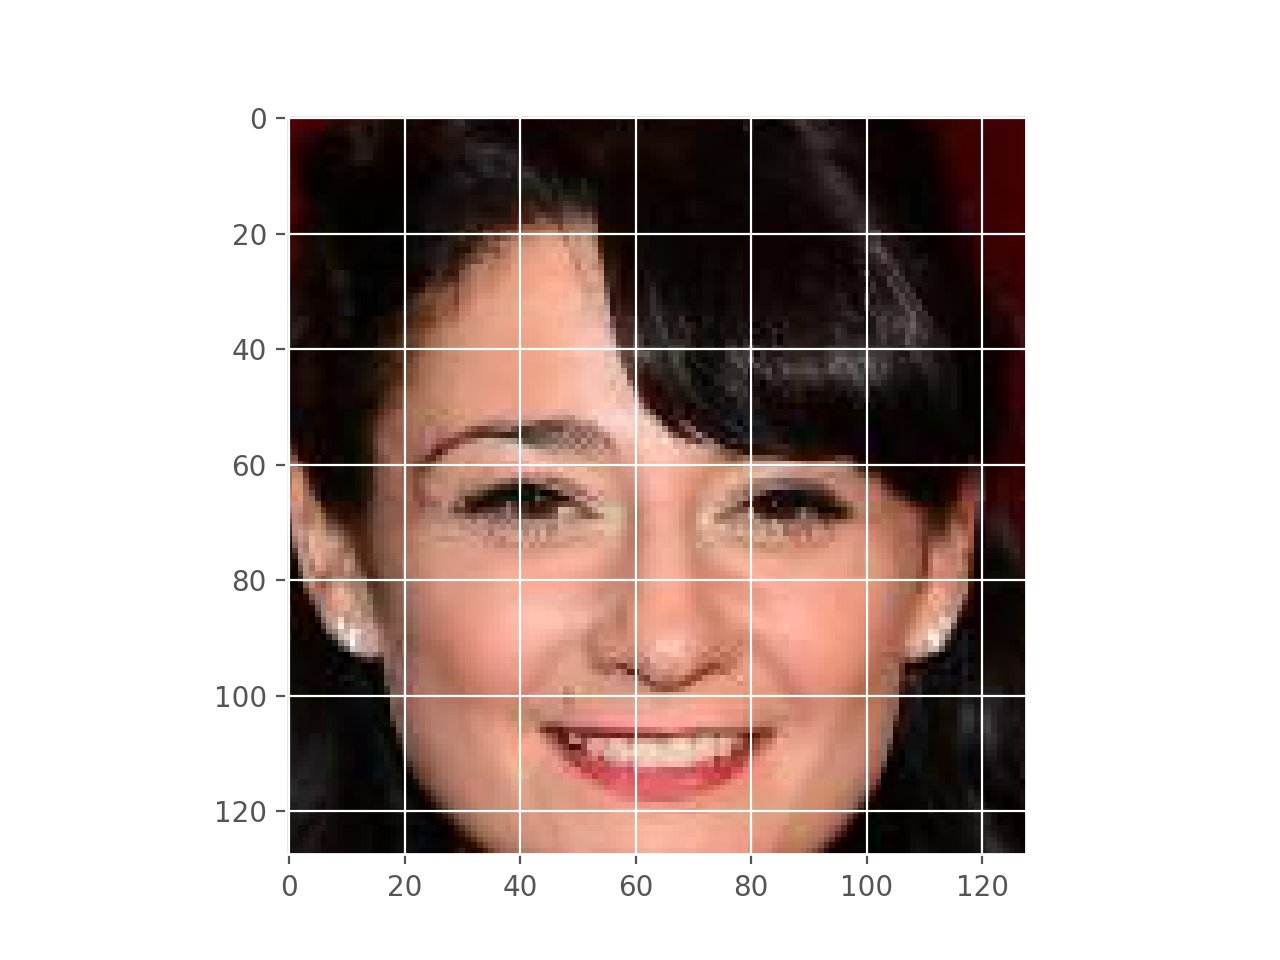

In [11]:
def center_crop_index(origin_len, crop_len):
    tmp = int(origin_len/2.0 - crop_len/2.0)
    c_start = tmp if tmp >= 0 else 0
    tmp = c_start + crop_len
    c_end = tmp if tmp <= origin_len else origin_len
    return c_start, c_end

def center_crop(img, crop_size):
    h_start, h_end = center_crop_index(img.shape[0], crop_size[1])
    c_start, c_end = center_crop_index(img.shape[1], crop_size[0])
    return img[h_start:h_end, c_start:c_end,...]

crop_img = center_crop(img, (128, 128))
plt.figure()
plt.imshow(crop_img)

In [13]:
from keras.models import load_model
import numpy as np
model = load_model('../data/bg60/vggnet_on_celeba.attrs.model')

%timeit model.predict(np.expand_dims(crop_img, axis=0))

55.5 ms ± 650 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
model = load_model('../data/bg60/vggnet_on_celeba.attrs.bn.model')
%timeit model.predict(np.expand_dims(crop_img, axis=0))

73.8 ms ± 3.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


最后给出一个表现vggnet在处理40个分类时的精度和速度的表格

|实验名称|图像大小|精度|耗时/帧|
|:----:|:----:|:----:|:----:|
|vggnet|128x128x3|90.17%|55.5ms|
|vggnet+batch-normalization|128x128x3|90.62%|73.8ms|

说明：精度测试在[CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)的测试集上进行，速度测试在2.3 GHz Intel Core i5的机器上进行。

从以上展示的精度而言，还有进一步的提升空间。特别是针对过拟合现象，可以加入dropout、数据增强以及调整网络复杂度等等。该算法模型能够完成一次预测40个人脸特征属性的任务，并具有90%以上的正确率，这对于患有脸盲症的笔者而言实在是技高一筹。

本文的实验代码github[链接](https://github.com/cnbluegeek/ml-models).